In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bhaktapri","key":"bbe1b17776179cefd3cc335965120bf4"}'}

In [3]:
! mkdir ~/.kaggle/

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d huberthamelin/garbage-classification-labels-corrections

 98% 489M/497M [00:08<00:00, 49.0MB/s]
100% 497M/497M [00:08<00:00, 64.3MB/s]


In [7]:
!unzip /content/garbage-classification-labels-corrections.zip

Streaming output truncated to the last 5000 lines.
  inflating: garbage_classification_enhanced/paper/paper48.jpg  
  inflating: garbage_classification_enhanced/paper/paper480.jpg  
  inflating: garbage_classification_enhanced/paper/paper481.jpg  
  inflating: garbage_classification_enhanced/paper/paper482.jpg  
  inflating: garbage_classification_enhanced/paper/paper483.jpg  
  inflating: garbage_classification_enhanced/paper/paper484.jpg  
  inflating: garbage_classification_enhanced/paper/paper485.jpg  
  inflating: garbage_classification_enhanced/paper/paper486.jpg  
  inflating: garbage_classification_enhanced/paper/paper487.jpg  
  inflating: garbage_classification_enhanced/paper/paper488.jpg  
  inflating: garbage_classification_enhanced/paper/paper489.jpg  
  inflating: garbage_classification_enhanced/paper/paper49.jpg  
  inflating: garbage_classification_enhanced/paper/paper490.jpg  
  inflating: garbage_classification_enhanced/paper/paper491.jpg  
  inflating: garbage_classi

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools


In [9]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-06-11 06:48:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-11 06:48:40 (117 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [10]:
df='/content/garbage_classification_enhanced'

In [11]:
walk_through_dir(df)

There are 12 directories and 0 images in '/content/garbage_classification_enhanced'.
There are 0 directories and 901 images in '/content/garbage_classification_enhanced/plastic'.
There are 0 directories and 1035 images in '/content/garbage_classification_enhanced/biological'.
There are 0 directories and 619 images in '/content/garbage_classification_enhanced/brown-glass'.
There are 0 directories and 1108 images in '/content/garbage_classification_enhanced/paper'.
There are 0 directories and 726 images in '/content/garbage_classification_enhanced/trash'.
There are 0 directories and 837 images in '/content/garbage_classification_enhanced/metal'.
There are 0 directories and 979 images in '/content/garbage_classification_enhanced/battery'.
There are 0 directories and 796 images in '/content/garbage_classification_enhanced/white-glass'.
There are 0 directories and 2006 images in '/content/garbage_classification_enhanced/shoes'.
There are 0 directories and 936 images in '/content/garbage_cla

In [12]:
Path(df)

PosixPath('/content/garbage_classification_enhanced')

In [13]:
image_dir = Path(df)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [14]:
image_df

,Filepath,Label
0,/content/garbage_classification_enhanced/plast...,plastic
1,/content/garbage_classification_enhanced/plast...,plastic
2,/content/garbage_classification_enhanced/plast...,plastic
3,/content/garbage_classification_enhanced/plast...,plastic
4,/content/garbage_classification_enhanced/plast...,plastic
...,...,...
15865,/content/garbage_classification_enhanced/green...,green-glass
15866,/content/garbage_classification_enhanced/green...,green-glass
15867,/content/garbage_classification_enhanced/green...,green-glass
15868,/content/garbage_classification_enhanced/green...,green-glass


[ 4432    41  3281 11787   424  1369 15388  4058  4030 14752 15473 12071
  4268 14500 10453 15812]


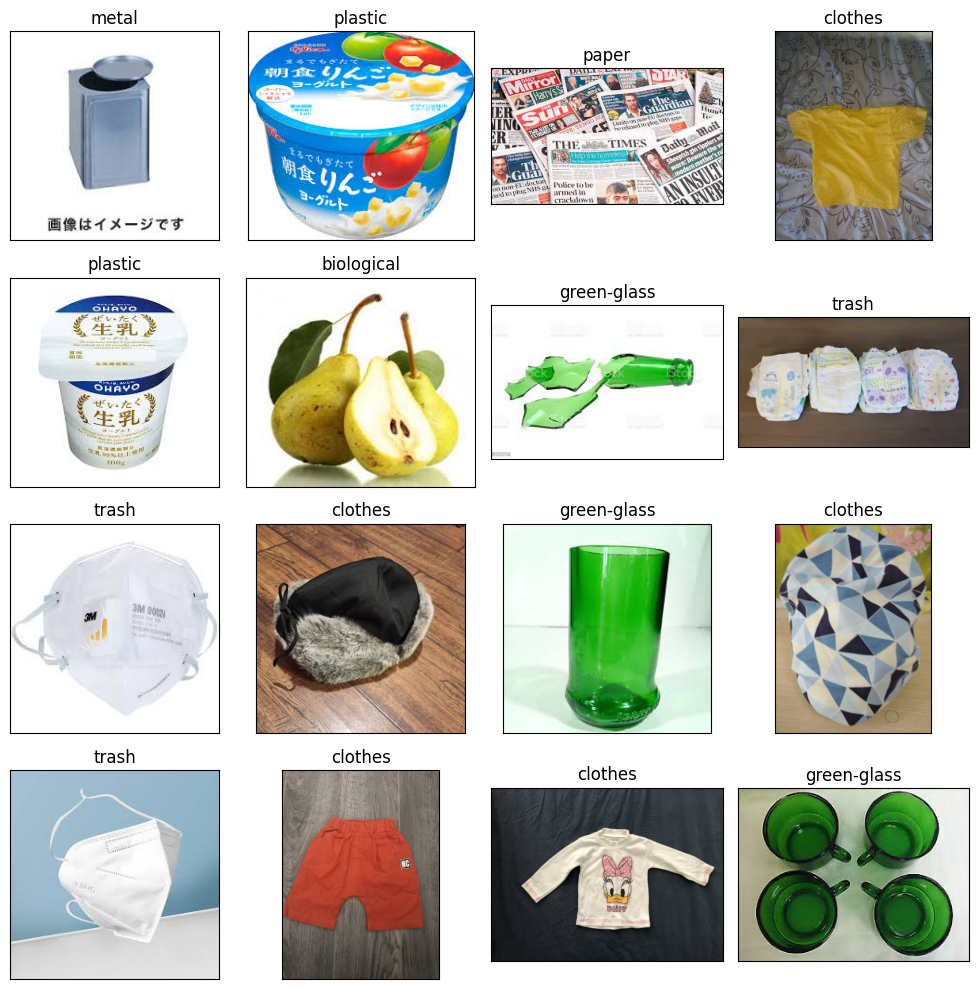

In [15]:
random_index = np.random.randint(0, len(image_df), 16)
print(random_index)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [16]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [17]:
train_df.shape

(12696, 2)

In [18]:
test_df.shape

(3174, 2)

In [19]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [20]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [21]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 10157 validated image filenames belonging to 12 classes.
Found 2539 validated image filenames belonging to 12 classes.
Found 3174 validated image filenames belonging to 12 classes.


In [22]:
print(train_images.classes[0:10])

[2, 7, 3, 0, 0, 5, 7, 4, 0, 4]


In [23]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  #layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [24]:
#Loading pretrained model
pretrained_model=tf.keras.applications.ResNet50(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
)

94765736/94765736 [==============================] - 0s 0us/step


In [25]:
pretrained_model.trainable = False

In [27]:
checkpoint_path = "garbage_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [28]:
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True)

In [29]:
inputs=pretrained_model.inputs
x = resize_and_rescale(inputs)
x=Dense(256,activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(12, activation='softmax')(x)

In [30]:
model=Model(inputs,outputs)

In [31]:
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [32]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    
)

Epoch 1/50
318/318 [==============================] - 74s 189ms/step - loss: 0.7450 - accuracy: 0.7710 - val_loss: 0.2424 - val_accuracy: 0.9330
Epoch 2/50
318/318 [==============================] - 58s 181ms/step - loss: 0.2614 - accuracy: 0.9173 - val_loss: 0.1689 - val_accuracy: 0.9464
Epoch 3/50
318/318 [==============================] - 57s 180ms/step - loss: 0.1849 - accuracy: 0.9398 - val_loss: 0.1459 - val_accuracy: 0.9504
Epoch 4/50
318/318 [==============================] - 58s 183ms/step - loss: 0.1063 - accuracy: 0.9655 - val_loss: 0.1292 - val_accuracy: 0.9551
Epoch 6/50
318/318 [==============================] - 57s 178ms/step - loss: 0.0902 - accuracy: 0.9715 - val_loss: 0.1231 - val_accuracy: 0.9594
Epoch 7/50
318/318 [==============================] - 58s 182ms/step - loss: 0.0758 - accuracy: 0.9754 - val_loss: 0.1222 - val_accuracy: 0.9594
Epoch 8/50
318/318 [==============================] - 68s 213ms/step - loss: 0.0556 - accuracy: 0.9822 - val_loss: 0.1175 - val_ac

In [33]:
history.history

{'loss': [0.744991660118103,
  0.2614150643348694,
  0.18493852019309998,
  0.13373272120952606,
  0.10626210272312164,
  0.0901511162519455,
  0.07575688511133194,
  0.05559305101633072,
  0.046301405876874924,
  0.03819303214550018,
  0.03230070695281029,
  0.028921160846948624,
  0.023442838340997696,
  0.01907157339155674,
  0.01533465925604105,
  0.014311117120087147,
  0.012090430594980717,
  0.011966428719460964,
  0.009187416173517704,
  0.006797737907618284,
  0.007049004081636667,
  0.0074718729592859745,
  0.005113564897328615,
  0.005890833679586649,
  0.006900243926793337,
  0.0065937768667936325,
  0.004178999457508326,
  0.00582036841660738,
  0.006621813401579857,
  0.006266285665333271,
  0.005331304855644703,
  0.006033298093825579,
  0.005422279704362154,
  0.0020322995260357857,
  0.0026567447930574417,
  0.0030382233671844006,
  0.0028867218643426895,
  0.002489387523382902,
  0.002557189902290702,
  0.004139655735343695,
  0.007356461603194475,
  0.003071191022172

In [34]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.23189
Test Accuracy: 95.59%


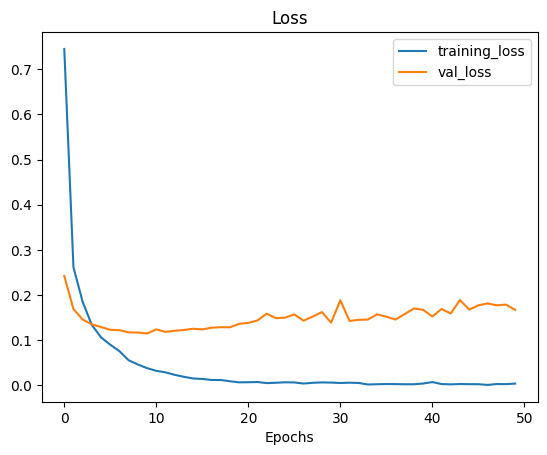

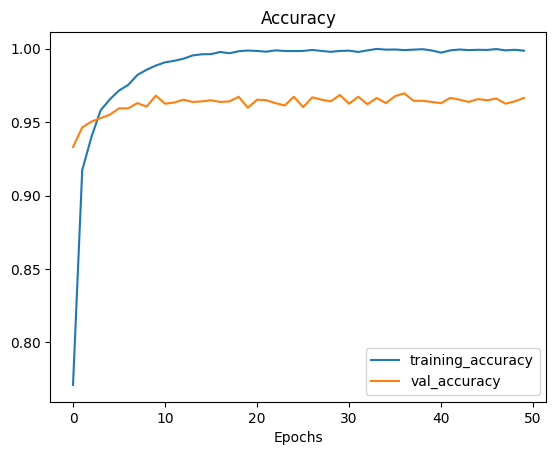

In [35]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [36]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

100/100 [==============================] - 17s 145ms/step
The first 10 predictions: ['brown-glass', 'clothes', 'battery', 'clothes', 'trash', 'brown-glass', 'shoes', 'clothes', 'biological', 'biological']


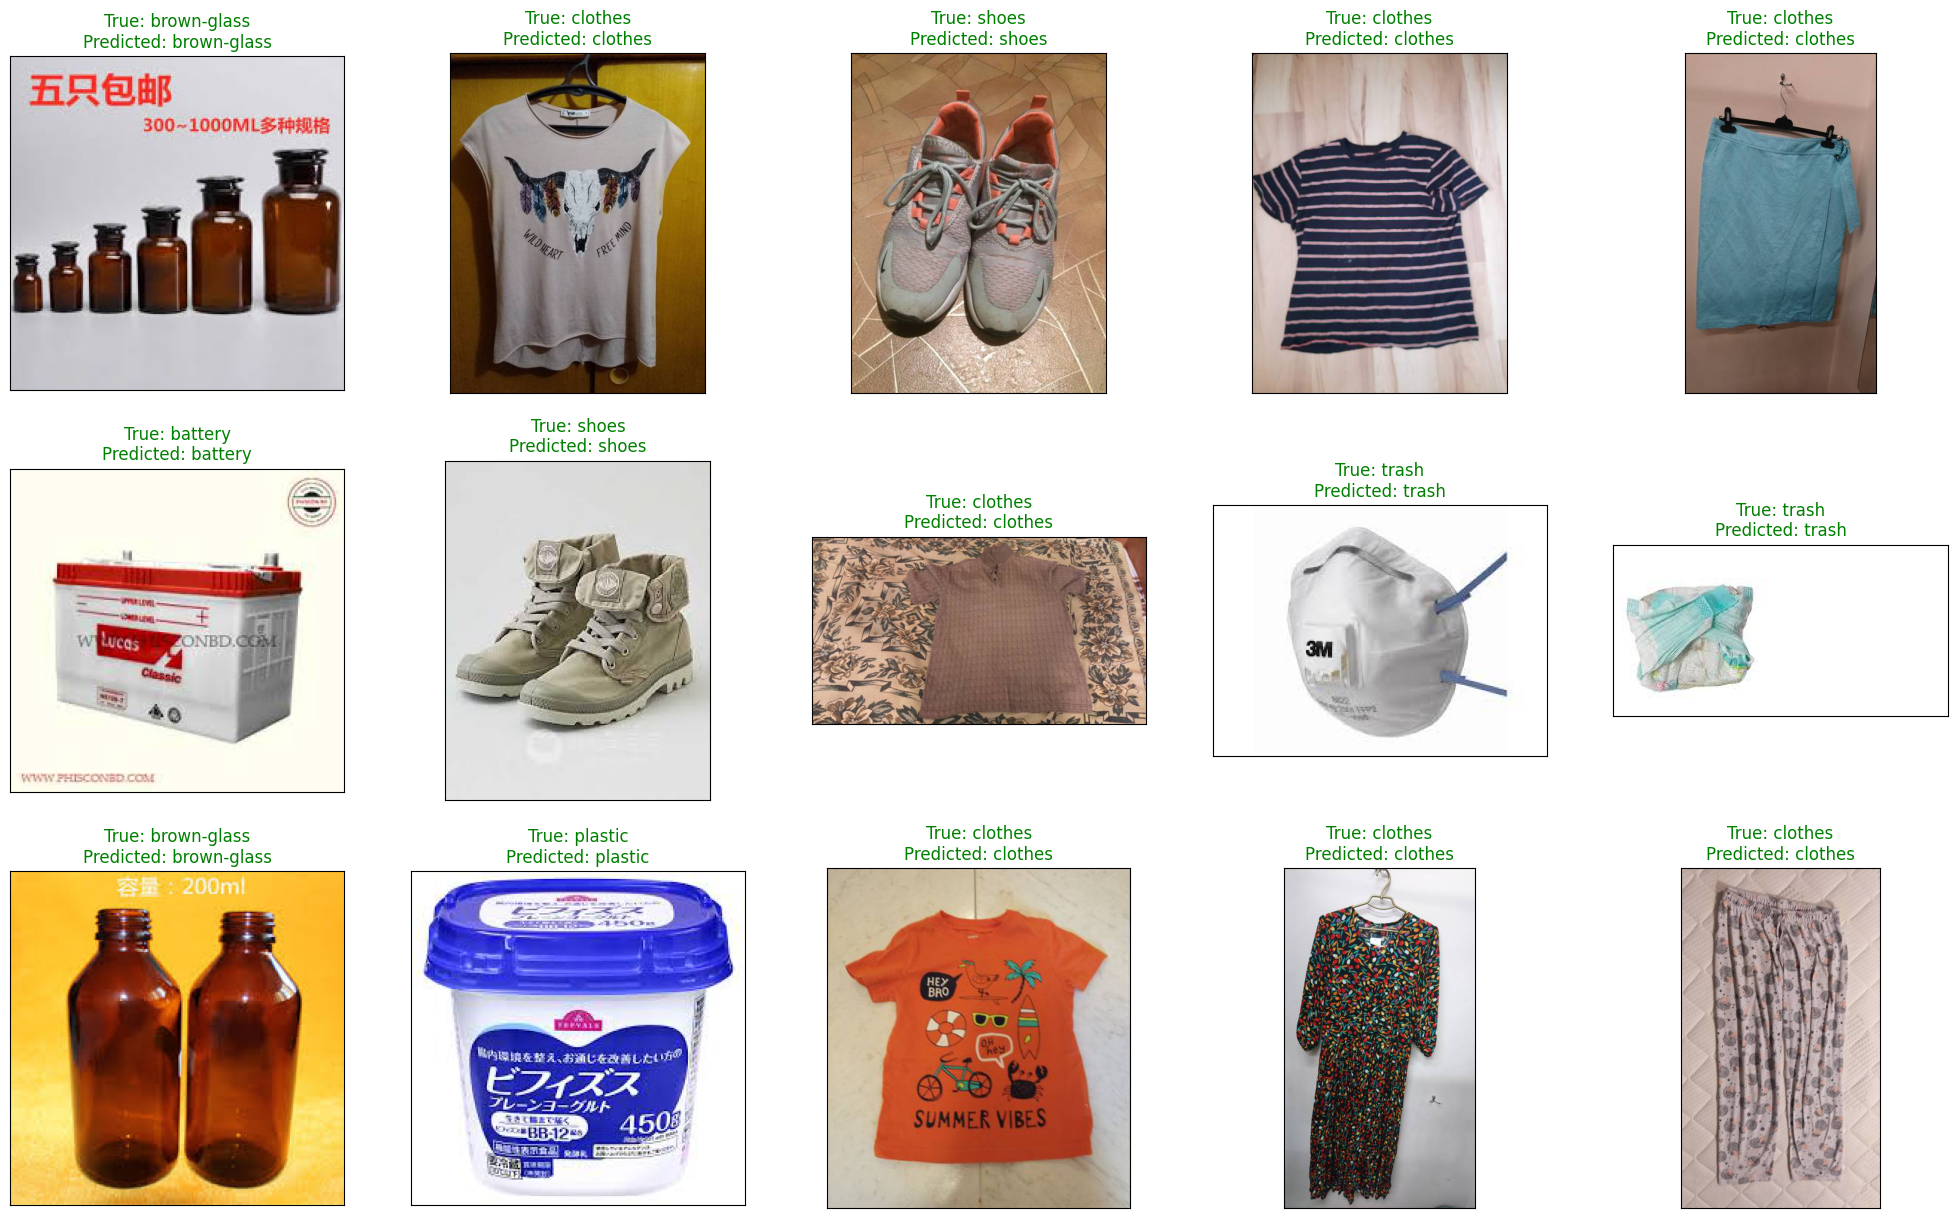

<Figure size 640x480 with 0 Axes>

In [37]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [38]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
battery,0.954338,0.990521,0.972093,211.000000
biological,0.953125,0.983871,0.968254,186.000000
brown-glass,0.953488,0.931818,0.942529,132.000000
cardboard,0.951613,0.926702,0.938992,191.000000
clothes,0.991237,0.989310,0.990272,1029.000000
green-glass,0.992000,0.925373,0.957529,134.000000
metal,0.877301,0.893750,0.885449,160.000000
paper,0.904977,0.938967,0.921659,213.000000
plastic,0.867021,0.895604,0.881081,182.000000
shoes,0.970046,0.985948,0.977933,427.000000


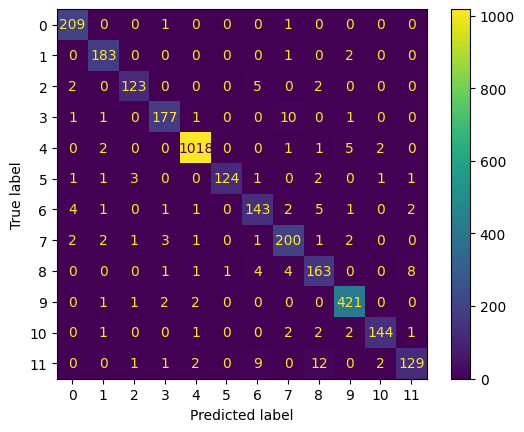

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [41]:
from tensorflow.keras.models import load_model

model.save('Garbage_classifier.h5')